# Gravity disturbance produced by a prism

The difference between the observed gravity (corrected from non-gravitational effects due to the vehicle motion) and the normal gravity, at the same point, is called *gravity disturbance* and is a very-well established quantity in geodesy (Hofmann-Wellenhof and Moritz, 2005). Several authors have discussed the differences between *gravity anomaly* and *gravity disturbance*, as well as proposed that the second is more appropriated for geophysical applications (e.g., Li and Götze, 2001; Fairhead et al., 2003; Hackney and Featherstone, 2003; Hinze et al., 2005; Vajda et al., 2006, 2007, 2008). The *gravity disturbance* approximates the gravitational field produced by contrasts between the actual internal density distribution of the Earth and the unknown internal density distribution of the normal Earth. In applied geophysics, these density differences are generally called *anomalous masses* (e.g., Hammer, 1945; LaFehr, 1965) or *gravity sources* (e.g., Blakely, 1996).

This code illustrates how to compute the *gravity disturbance* produced by a homogeneous rectangular prism at points free of mass. We presume that the *gravity disturbance* can be approximated by the vertical component of the gravitational attraction produced by the prism.

**Note:** Find all cited references at [`references.md`](https://github.com/birocoles/gravmag/blob/main/references.md).

### Things we have to import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
import noise

from gravmag.models import rectangular_prism as rp
from gravmag import plot_functions as plf

/home/vanderlei/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Model

In [2]:
# Create a model formed by a single prism
model = np.array([[-500, 500, 0, 2000, 10, 1010],
                  [-1500, -500, 1000, 3000, 100, 1200],
                  [2000, 3000, 2000, 2500, 90, 1500]])

density = np.array([1500, 1800, 3000]) # 2000 kg/m³ = 2 g/cm³

### Points were we compute the synthetic data

In [3]:
# number of points along x and y
shape = (100, 100)

# minimum x, maximum x, minimum y and maximum y
area = [-5000, 5000, -4000, 6000]

# coordinates 
xp = np.linspace(area[0], area[1], shape[0])
yp = np.linspace(area[2], area[3], shape[1])
yp, xp = np.meshgrid(yp, xp)

yp = np.ravel(yp)
xp = np.ravel(xp)

In [4]:
# Generate a synthetic random topography with the Python package [`noise`](https://pypi.org/project/noise/),
# by following the example presented at [Jack McKew's Blog](https://jackmckew.dev/3d-terrain-in-python.html)

# parameters controlling the synthetic topography
scale = 100.0
octaves = 6
persistence = 0.8
lacunarity = 4.0
terrain_amplitude = 100.
terrain_base = -20.

# generate the topography
zp = np.zeros(shape)
for i in range(shape[0]):
    for j in range(shape[1]):
        zp[i][j] = noise.pnoise2(i/scale, 
                                 j/scale, 
                                 octaves=octaves, 
                                 persistence=persistence, 
                                 lacunarity=lacunarity, 
                                 repeatx=100, 
                                 repeaty=100, 
                                 base=0)

zp = (
    terrain_base - terrain_amplitude*(
        (zp - np.min(zp))/(np.max(zp) - np.min(zp))
    )
)

zp = zp.ravel()

In [5]:
coordinates = np.vstack([xp, yp, zp])

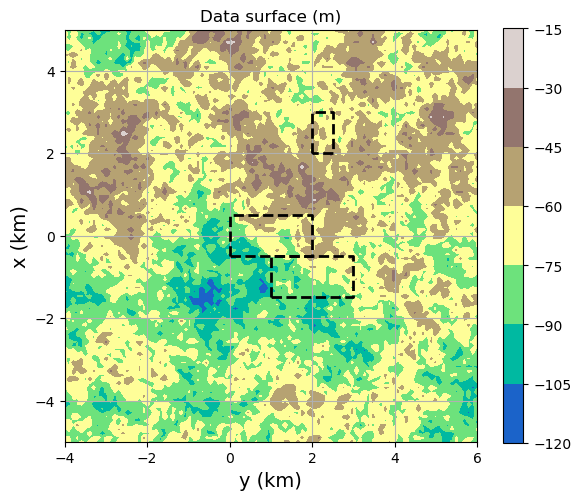

In [6]:
plt.figure(figsize=(6,5))

plt.title("Data surface (m)")
plt.axis('scaled')
plt.contourf(yp.reshape(shape)*0.001, 
             xp.reshape(shape)*0.001, 
             zp.reshape(shape), cmap='terrain')
plt.colorbar()
plf.model_boundaries(model)
plt.ylim(0.001*area[0], 0.001*area[1])
plt.xlim(0.001*area[2], 0.001*area[3])
plt.xlabel('y (km)', fontsize=14)
plt.ylabel('x (km)', fontsize=14)
plt.grid()
plt.tight_layout()

plt.show()

### Synthetic gravity disturbance (in mGal)

In [7]:
# Compute the vertical component of acceleration
gz = rp.grav(coordinates=coordinates, prisms=model, density=density, field='z')

### Plot the computed gravity disturbance with Matplotlib

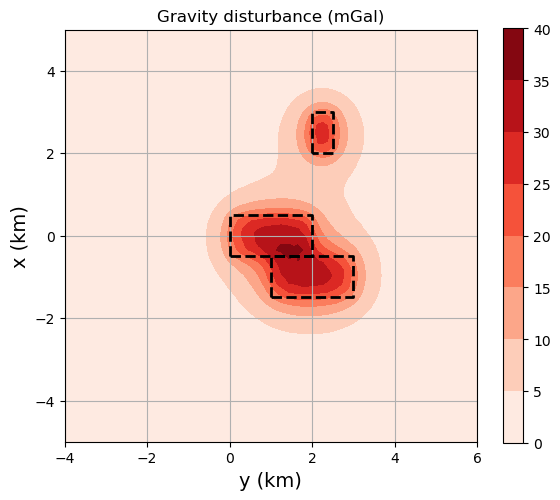

In [8]:
plt.figure(figsize=(6,5))

plt.title("Gravity disturbance (mGal)")
plt.axis('scaled')
plt.contourf(yp.reshape(shape)*0.001, 
             xp.reshape(shape)*0.001, 
             gz.reshape(shape), cmap='Reds')
plt.colorbar()
plf.model_boundaries(model)
plt.ylim(0.001*area[0], 0.001*area[1])
plt.xlim(0.001*area[2], 0.001*area[3])
plt.xlabel('y (km)', fontsize=14)
plt.ylabel('x (km)', fontsize=14)
plt.grid()
plt.tight_layout()

plt.show()

### Plot the computed gravity disturbance and the model with PyVista

In [9]:
model_mesh = plf.prisms_to_pyvista(model, density)

In [10]:
data_mesh = plf.data_to_surface_pyvista(coordinates, gz)

In [13]:
pl = pv.Plotter()

# parameters of data colorbar
data_sargs = dict(
    title='gravity disturbance (mGal)',
    title_font_size=20,
    label_font_size=16,
    shadow=True,
    n_labels=7,
    italic=True,
    fmt="%.1f",
    font_family="arial",
)

# add data
pl.add_mesh(
    data_mesh,
    scalars='data',
    cmap='Reds',
    #interpolate_before_map=True,
    #style='surface',
    #style='points',
    #render_points_as_spheres=True,
    #point_size=4,
    #lighting=True,
    smooth_shading=True,
    scalar_bar_args=data_sargs,
    opacity=0.70
)

# parameters of model colorbar
model_sargs = dict(
    title='density (kg/m³)',
    title_font_size=20,
    label_font_size=16,
    shadow=True,
    n_labels=7,
    italic=True,
    fmt="%.1f",
    font_family="arial",
)

# add model
pl.add_mesh(
    model_mesh,
    scalars='prop',
    cmap='viridis',
    lighting=True,
    scalar_bar_args=model_sargs,
    show_edges=True,
)

# set visualization parameters
#pl.set_scale(zscale=1)  # exaggerate the vertical coordinate
#pl.camera_position = "xz"
#pl.camera.elevation = 200
#pl.camera.azimuth = 90
#pl.camera.zoom(1)


#pl.show_bounds(location='front')

pl.show(return_img=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)